In [18]:
import sys
sys.path.append("..")
from src.feature_extraction.bag_of_words import bag_of_words
from src.feature_extraction.sentiment_score_english import sentiment_score_english
from src.feature_extraction.tfidf_from_bow import tfidf_from_bow
from src.feature_extraction.tokenize import tokenize
from src.feature_extraction.w2v_embeddings import w2v_embeddings_from_sentences
from src.feature_extraction.w2i import w2i
from src.preprocess.data_prep_offenseval import DataPrepOffensEval
import tensorflow as tf
from tensorflow import keras


In [57]:
file_path = "../data/raw/OffensEval2019/start-kit/training-v1/offenseval-training-v1.tsv"
dp = DataPrepOffensEval()
result_tuple = dp.get_X_and_ys(file_path=file_path)
X = result_tuple[0]
y_sub_a = result_tuple[1]
y_sub_b = result_tuple[2]
y_sub_c = result_tuple[3]
sub_a_mapping = result_tuple[4]
sub_b_mapping = result_tuple[5]
sub_c_mapping = result_tuple[6]

In [59]:
X, w2i_dict, i2w_dict = w2i(X)

In [60]:
# Create a validation set with 20% of the data
X_train, X_val, y_sub_a_train, y_sub_a_val = dp.train_test_split(X, y_sub_a, test_size=0.2)

In [61]:
# Build the model
# Start of with an embedding layer with output size of 100
# Then Bi-Directional LSTMs
# Then 1 Dense Layer, maybe hidden size of 16?
# Then dense, with sigmoid
model = keras.Sequential()
model.add(keras.layers.Embedding(
    input_dim=len(w2i_dict), 
    output_dim=10,
))
model.add(keras.layers.Bidirectional(
    layer=keras.layers.LSTM(5),
    merge_mode="concat",
))
model.add(keras.layers.Dense(
    8,
    activation=tf.nn.relu,
))
model.add(keras.layers.Dense(
    1, 
    activation=tf.nn.sigmoid,
))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 10)          218520    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 10)                640       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 219,257
Trainable params: 219,257
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=['accuracy', 'categorical_accuracy']
)

In [63]:
history = model.fit(
    X_train, 
    y_sub_a_train,
    epochs=10, 
    batch_size=512, 
    validation_data=(X_val, y_sub_a_val),
    verbose=1,
)

Train on 10592 samples, validate on 2648 samples
Epoch 1/10
10592/10592 [==============================] - 4s 403us/sample - loss: 0.6855 - acc: 0.6188 - categorical_accuracy: 1.0000 - val_loss: 0.6715 - val_acc: 0.6820 - val_categorical_accuracy: 1.0000
Epoch 2/10
10592/10592 [==============================] - 2s 206us/sample - loss: 0.6622 - acc: 0.6641 - categorical_accuracy: 1.0000 - val_loss: 0.6444 - val_acc: 0.6820 - val_categorical_accuracy: 1.0000
Epoch 3/10
10592/10592 [==============================] - 2s 202us/sample - loss: 0.6359 - acc: 0.6641 - categorical_accuracy: 1.0000 - val_loss: 0.6179 - val_acc: 0.6820 - val_categorical_accuracy: 1.0000
Epoch 4/10
10592/10592 [==============================] - 2s 200us/sample - loss: 0.6169 - acc: 0.6641 - categorical_accuracy: 1.0000 - val_loss: 0.6070 - val_acc: 0.6820 - val_categorical_accuracy: 1.0000
Epoch 5/10
10592/10592 [==============================] - 2s 201us/sample - loss: 0.5905 - acc: 0.6641 - categorical_accuracy: 

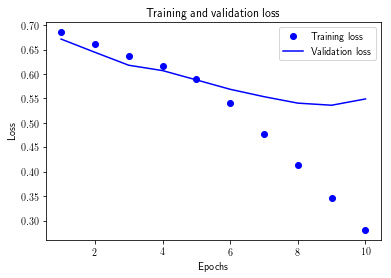

In [64]:
# Plot train and validation loss to evaluate overfitting
history_dict = history.history
import matplotlib.pyplot as plt
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

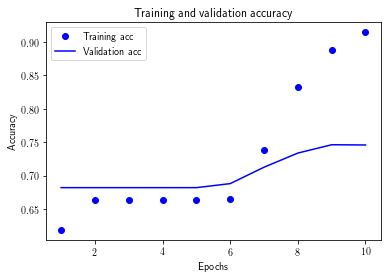

In [65]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [66]:
y_pred = model.predict(X_val)
y_pred_binary = []

for value in y_pred:
    v = value[0]
    if v < 0.5:
        y_pred_binary.append(0)
    else: 
        y_pred_binary.append(1)

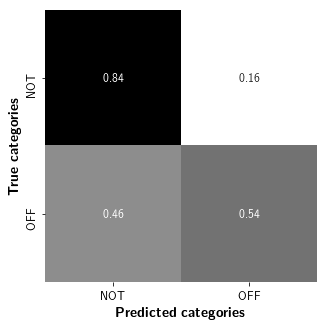

Precision: [0.79582245 0.61527967]
Recall: [0.84385382 0.53562945]
F1 Score: [0.81913464 0.57269841]
Accuracy: 0.745845921450151



In [67]:
from src.classifiers.classifier_dummy import DummyClassifier as C
clf = C()
confusion_matrix = clf.confusion_matrix(y_sub_a_val, y_pred_binary, 2, ["NOT", "OFF"])
clf.plot_confusion_matrix(confusion_matrix)


precision = clf.precision(y_sub_a_val, y_pred_binary)
recall = clf.recall(y_sub_a_val, y_pred_binary)
f1_score = clf.f1_score(y_sub_a_val, y_pred_binary)
accuracy = clf.accuracy(y_sub_a_val, y_pred_binary)

print("Precision: {}\nRecall: {}\nF1 Score: {}\nAccuracy: {}\n".format(
    precision, 
    recall, 
    f1_score, 
    accuracy,
))